<p style="text-align: center;">🍕🍔🍟🌭🍿🧂🥓🥚🥯🥨🎂🍪☕🥐🍞🌮🥪🥟<br>
</p>
<span style="font-size:28px;"><p style="text-align: center;"> Next word prediction with LSTMs. Generating food reviews. </p></span>

<p style="text-align: center;">🧈🥞🧇🍳🥖🍖🍗🍩🍵🍼🧀🥗🥩🍱🥫🌯🥡🥠
</p>

In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
import emoji
from nltk.tokenize.treebank import TreebankWordDetokenizer
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt

**Setting up the global variable that will be utilized throughout the process.**

In [2]:
BATCH_SIZE = 32
VALIDATION_STEPS = 50
TOTAL_TRAINING_STEPS = 100000
EVAL_EVERY_N_STEPS = 1000
MODEL_NAME = 'lstm_model'
VOCAB_SIZE = 10004
MAX_REVIEW_LEN = 1500
INITIAL_LEARNING_RATE = 1e-3
DECAY_STEPS = 50000
DECAY_RATE = 0.5
GENERATED_REVIEW_MAX_LEN = 500
LSTM_UNITS = [512,1024]
DENSE_UNITS = 1024
EMBEDDING_OUTPUT_DIM = 256

# Data preprocessing #
Reading data, making train and val split, visualizing reviews' lengths.

In [3]:
path = '/kaggle/input/amazon-fine-food-reviews/Reviews.csv'
reviews = pd.read_csv(path, usecols=['Text'])
reviews = np.squeeze(reviews, axis = 1)
reviews = np.unique(reviews)
reviews_train, reviews_val = train_test_split(reviews, test_size=0.1,random_state=2409)

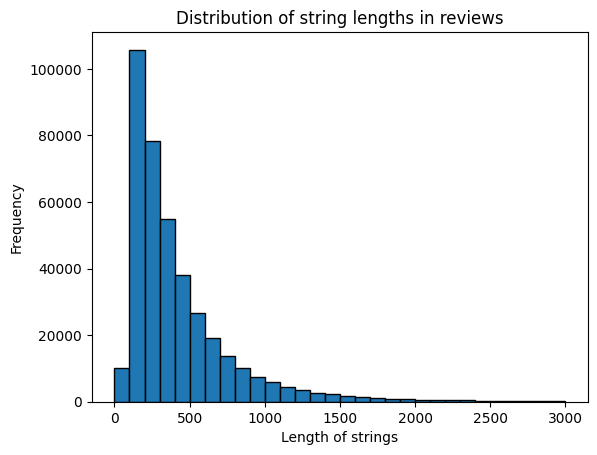

In [4]:
length_of_strings = np.vectorize(len)(reviews)
plt.hist(length_of_strings, bins=np.arange(0, 3001, 100), edgecolor='black')
plt.xlabel('Length of strings')
plt.ylabel('Frequency')
plt.title('Distribution of string lengths in reviews')
plt.show()

In [5]:
print(reviews_train[0],'\n')
print(reviews_train[2],'\n')
print(reviews_val[0],'\n')
print(reviews_val[4])

I always ask for lemon with my water. This is a great alternative to real lemons and just as delicious. 

These are some of the most FABULOUS crackers I have EVER tasted! They are a MUST when wine tasting, and in fact, are terrific any time you are serving wine and cheese. LOVE THEM!!! 

Really unfortunate.  This tastes like neither bacon nor mayo.  Not good at all.  I really wanted to like this, but not for me at all!  I am amazed at the positive comments, I just don't know what it tastes like at all.  Salty, and creamy - but not like bacon! 

I was trying to find a source for hot-smoked, shelf-stable salmon. Several brands are available through Amazon and its affiliates and I ordered a range of them to test. This is the superior product (though I gather that the King Salmon in this brand is even one step higher). It is a beautiful orange/red colour and has moist flesh with a rich and lively flavour (without excessive smoke penetration). Other brands (which had 5-star ratings) were mu

# Vocabulary #

**The following commented cells demonstrate the creation of our vocabulary dictionary. We won't execute them due to the extended processing time, as the provided notebook already includes the pre-established vocabulary.**


1. We consolidated all reviews into a single string, employing `nltk.tokenize.word_tokenize` for effective word and punctuation separation.

2. Following that, we computed the frequency of each word, splitting the resulting dictionary into values and keys. This step facilitated the creation of a vocabulary with words arranged in descending order of frequency.

3. Opting for a vocabulary size of 10,000, we arrived at this decision based on the observed ≈28:1 ratio between vocabulary words and unknown words, deeming it an acceptable balance.

4. Our vocabulary was efficiently preserved for future use using the pickle module.

In [6]:
#train_string = ' '.join(reviews_train)
#words_list = nltk.tokenize.word_tokenize(train_string)

In [7]:
#words_and_frequency = nltk.FreqDist(words_list)
#counts = list(words_and_frequency.values())
#words = list(words_and_frequency.keys())
# counts = np.array(counts)
# words =np.array(words)

In [8]:
# count_sort_ind = np.argsort(-counts)

In [9]:
# words = words[count_sort_ind]
# counts = counts[count_sort_ind]

In [10]:
# counts[:10000].sum()/counts[10000:].sum()

In [11]:
# vocabulary = dict(zip(words, counts))
# with open('vocabulary.pkl', 'wb') as fp:
#     pickle.dump(vocabulary, fp)

In [12]:
# Read dictionary pkl file
with open('/kaggle/input/vocabulary/vocabulary.pkl', 'rb') as fp:
    vocabulary = pickle.load(fp)

**Adding special tokens (padding, start of sentence, end of sentence, unknown) to our vocabulary.**

**We are creating dictionaries to map strings to indices and vice versa.**

In [13]:
word2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3}
word2idx_update = dict(zip(vocabulary.keys(), range(4,VOCAB_SIZE)))

In [14]:
word2idx.update(word2idx_update)
for i,j in zip(range(7),word2idx.items()):
    print(i,j)

0 ('<PAD>', 0)
1 ('<SOS>', 1)
2 ('<EOS>', 2)
3 ('<UNK>', 3)
4 ('.', 4)
5 (',', 5)
6 ('I', 6)


In [15]:
idx2word = dict(zip( word2idx.values(),word2idx.keys()))
for i,j in zip(range(7),idx2word.items()):
    print(i,j)

0 (0, '<PAD>')
1 (1, '<SOS>')
2 (2, '<EOS>')
3 (3, '<UNK>')
4 (4, '.')
5 (5, ',')
6 (6, 'I')


# Creating tensorflow datasets

In [16]:
def tokenize(review):
    """
    Split reviews into tokens.
    """
    review = review.decode('utf-8')
    words_list = nltk.tokenize.word_tokenize(review)
    index_list = [word2idx['<SOS>']]
    for word in words_list:
        index = word2idx.get(word,word2idx['<UNK>'])
        index_list.append(index)
    index_list.append(word2idx['<EOS>'])
    return np.array(index_list).astype(np.int32)

def map_fn(review):
    """
    Tokenize the elements and set a maximum review length of 1500 characters.
    """
    x = tf.numpy_function(tokenize, inp = [review], Tout = tf.int32)
    x = tf.ensure_shape(x, [None])
    return x[:MAX_REVIEW_LEN]

def batch_map_fn(batch):
    """
    Generate inputs by excluding the last element, and create targets by excluding the first element.
    """
    x=tf.shape(batch) 
    inputs = batch[:,0:x[1]-1]
    outputs = batch[:,1:x[1]]
    return inputs, outputs

In [17]:
def make_dataset(reviews, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices(reviews)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_fn, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.padded_batch(batch_size = BATCH_SIZE, padding_values=word2idx['<PAD>'] , drop_remainder = True)
    dataset = dataset.map(batch_map_fn, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
dataset_train = make_dataset(reviews_train, shuffle=True) # (inputs, targets)
dataset_val = make_dataset(reviews_val, shuffle=True) # (inputs, targets)

# Building model

## LSTM MODEL

In [19]:
class LSTMBlock(tf.keras.layers.Layer):
    """
    A class designed to dynamically generate LSTM layers according to a specified list of units.
    """
    def __init__(self, name='lstm_block'):
        super(LSTMBlock, self).__init__(name=name)
        self.lstm_list=[]        
        for units in LSTM_UNITS:            
            self.lstm_list.append(LSTM(units, return_sequences=True))
                
    def call(self,x, training):
        for lstm in self.lstm_list:
            x = lstm(x, training=training)
        return x        

class LSTMModel(Model):
    """
    Class that accepts input data and processes it through the layers of a model.
    """
    def __init__(self, name='food_review_generation'):
        super(LSTMModel, self).__init__(name=name)
        self.embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_OUTPUT_DIM)
        self.lstm_block = LSTMBlock()
        self.dense = Dense (DENSE_UNITS, activation='relu')
        self.output_layer = Dense(VOCAB_SIZE)
        
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.lstm_block(x, training)
        x = self.dense(x)
        x = self.output_layer(x)
        return x
    
    def model(self):
        x = Input((None,))
        return Model(inputs=x, outputs=self.call(x, True))

## CNN MODEL

In [20]:
class ResidualBlock(tf.keras.layers.Layer):
    """
    Creates one residual block with two convs.
    """
    def __init__(self, conv_config, name='residual_block'):
        super(ResidualBlock, self).__init__(name=name)
        self.conv_list=[]
        for filters, kernel_size, dilation_rate in conv_config:
            self.conv_list.append(Conv1D(filters, kernel_size, padding=PADDING,
                                         activation=None, dilation_rate=dilation_rate))

        self.filters = filters

    def build(self, input_shape):
        if input_shape[-1] != self.filters:
            self.dense = Conv1D(self.filters, 1, padding=PADDING, activation=None, dilation_rate=1)
        
        super(ResidualBlock, self).build(input_shape=input_shape)
        
    def call(self, inputs):
        x = inputs
        for conv in self.conv_list:
            y = relu(x)
            x = conv(y)

        if inputs.shape != x.shape:
            inputs = self.dense(inputs)
            
        return inputs + x
    

class CNNModel(Model):

    def __init__(self, name='food_review_generation'):
        super(CNNModel, self).__init__(name=name)
        self.embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_OUTPUT_DIM)
        self.conv1D = Conv1D(CONV_FILTERS, KERNEL_SIZE, padding = PADDING, name = 'conv1')
        
        self.block_list=[]
        for block, conv_config in enumerate(CONV_CONFIGS):
            self.residual_block = ResidualBlock(conv_config, name=f'res_block{block}')
            self.block_list.append(self.residual_block)
        
        self.dense = Dense(DENSE_UNITS, activation='relu')
        self.output_layer = Dense(VOCAB_SIZE)
        
    def call(self, inputs):
        x = self.embedding(inputs)    
        x = self.conv1D(x)
        for block in self.block_list:
            x = block(x)
            
        x = relu(x)
        x = self.dense(x)
        x = self.output_layer(x)
        return x
    
    def model(self):
        x = Input((None,))
        return Model(inputs=x, outputs=self.call(x)) 

## TRANSFORMER MODEL

In [21]:
def transformer_block(inputs):
    x = MultiHeadAttention(TRANSFORMER_HEADS, TRANSFORMER_CHANNELS//TRANSFORMER_HEADS,
                           TRANSFORMER_CHANNELS//TRANSFORMER_HEADS)(inputs, inputs, inputs, use_causal_mask=True)
    inputs = LayerNormalization(axis=-1, epsilon=1e-6)(inputs + x)
    x = Dense(TRANSFORMER_CHANNELS*4, activation='relu')(inputs)
    x = Dense(TRANSFORMER_CHANNELS)(x)
    inputs = LayerNormalization(axis=-1, epsilon=1e-6)(inputs + x)
    return inputs

def transformer_model():
    position_embedding = PositionEmbedding(max_length=MAX_REVIEW_LEN)
    inputs = Input((None,)) 
    x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_OUTPUT_DIM)(inputs)
    x = x+position_embedding(x)
    for block in range(TRANSFORMER_BLOCK_NUMBER):
        x = transformer_block(x)
    outputs = Dense(VOCAB_SIZE)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [22]:
if 'lstm' in MODEL_NAME:
    model = LSTMModel()
    model.model().summary()
elif 'cnn' in MODEL_NAME:
    model = CNNModel()
    model.model().summary()
elif 'transformer' in MODEL_NAME:
    model = transformer_model()
    model.summary()
else:
    raise NotImplementedError(f'uuuuuh model {MODEL_NAME} type unknown!!!')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2561024   
                                                                 
 lstm_block (LSTMBlock)      (None, None, 1024)        7870464   
                                                                 
 dense (Dense)               (None, None, 1024)        1049600   
                                                                 
 dense_1 (Dense)             (None, None, 10004)       10254100  
                                                                 
Total params: 21735188 (82.91 MB)
Trainable params: 21735188 (82.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Custom metrics
We created custom loss and accuracy to provide better model evaluation because we used masking to remove padding out of metrics calculations.

In [23]:
class MaskedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    """
    Sparse categorical crossentropy excluding padding in the calculation.
    """
    def __init__(self, name='masked_sparse_categorical_crossentropy', **kwargs):
        super(MaskedSparseCategoricalCrossentropy, self).__init__(name=name, **kwargs)
        self.scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):     
        
        loss = self.scce(y_true, y_pred) # y_true(B,T) y_pred(B,T,C)
        mask = tf.where(y_true == word2idx['<PAD>'], 0., 1.) # (B,T)
        loss = tf.reduce_sum(loss * mask)/ tf.reduce_sum(mask) # ()
        return loss
    
def get_tokens(logits):
    """
    Converts logits into tokens using argmax and random sampling, incorporating the Gumbel noise trick.
    """
    y_pred_argmax = tf.argmax(logits, axis=-1, output_type=tf.int32)
    
    rand_uniform = tf.random.uniform(tf.shape(logits), minval=1e-5, maxval=1. - 1e-5)
    gumbel_noise = -tf.math.log(-tf.math.log(rand_uniform))
    y_pred_sampling = tf.argmax(logits + gumbel_noise, axis=-1, output_type=tf.int32)
    return y_pred_argmax, y_pred_sampling

    
def masked_sparse_categorical_accuracy(y_true, y_pred): 
    mask = tf.where(y_true == word2idx['<PAD>'], 0., 1.) # (B,T)
    accuracy = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32)*mask)/tf.reduce_sum(mask)
    return accuracy


# Callbacks
Create model saving and loading + TB callbacks.

In [24]:
def create_checkpoint_manager(checkpoint_path, model, optimizer, max_allowed_checkpoints=5):
    checkpoint_starter = tf.Variable(0, trainable=False, dtype=tf.int32)
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model, checkpoint_starter=checkpoint_starter)
    manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_path, max_to_keep=max_allowed_checkpoints)    
    return manager

def save_checkpoint(step, checkpoint_manager):
    checkpoint_manager.checkpoint.checkpoint_starter.assign(step)
    checkpoint_manager.save(step)
    
def load_checkpoint_if_exists(manager):
    checkpoint_path = manager.directory
    checkpoint = manager.checkpoint
    try:
        checkpoint_state = tf.train.get_checkpoint_state(checkpoint_path)
        if checkpoint_state and checkpoint_state.model_checkpoint_path:
            print('Loading checkpoint from: {}'.format(checkpoint_state.model_checkpoint_path))
            checkpoint.restore(checkpoint_state.model_checkpoint_path)
        
        else:
            print('No model to load at {}'.format(checkpoint_path))
    
    except tf.errors.OutOfRangeError as e:
        raise tf.errors.OutOfRangeError('Cannot restore checkpoint: {}'.format(e))
    
def tensorboard_log(summary_writer, loss_value, argmax_accuracy, sampling_accuracy, step):
    with summary_writer.as_default():
        tf.summary.scalar('loss', loss_value, step=step)
        tf.summary.scalar('argmax_accuracy', argmax_accuracy, step=step)
        tf.summary.scalar('sampling_accuracy', sampling_accuracy, step=step)
    summary_writer.flush()


**Utility functions to detokenize targets and model outputs for visualization purposes.**

In [25]:
detokenizer = TreebankWordDetokenizer()

def detokenize_x(x):
    """
    Converts tokens into words for our input samples.
    """
    token_list_x = []
    for token in x:
        if token != word2idx['<PAD>']:
            word = idx2word[token]
            token_list_x.append(word)
    limit = len(token_list_x)
    print('Input: ',detokenizer.detokenize(token_list_x))
    print('')
    return limit

def detokenize_y(y, limit, argmax_or_sampling):
    """
    Converts tokens into words of the same length as input sample.
    """
    token_list_y = []
    for token in y[:limit]:
        word = idx2word[token]
        token_list_y.append(word)
    print(argmax_or_sampling,detokenizer.detokenize(token_list_y))
    print('')    

# Creating train and val step graphs

In [26]:
@tf.function(input_signature=[tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32), tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32)])
def train_step( x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value, logits

@tf.function(input_signature=[tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32), tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32)])
def val_step(x,y):
    logits = model(x, training=False)
    loss_value = loss_fn(y, logits)
    return loss_value, logits

def validate(dataset_val, step, data_name):
    avg_val_loss = 0.
    avg_val_argmax_acc = 0.
    avg_val_sampling_acc = 0.

    for i,(x_batch_val, y_batch_val) in zip(range(VALIDATION_STEPS),dataset_val):
        loss_value, logits = val_step(x_batch_val, y_batch_val) 
        avg_val_loss += loss_value 

        y_pred_argmax, y_pred_sampling = get_tokens(logits)
        val_argmax_acc = masked_sparse_categorical_accuracy(y_batch_val, y_pred_argmax)
        val_sampling_acc = masked_sparse_categorical_accuracy(y_batch_val, y_pred_sampling)
        avg_val_argmax_acc += val_argmax_acc
        avg_val_sampling_acc += val_sampling_acc

    avg_val_loss /= (i + 1)
    avg_val_argmax_acc /= (i + 1)
    avg_val_sampling_acc /= (i + 1)
    print(f"{data_name} loss at step {step}: {avg_val_loss:.4f}")
    print(f"{data_name} argmax acc at step {step}: {avg_val_argmax_acc:.2f}")
    print(f"{data_name} sampling acc at step {step}: {avg_val_sampling_acc:.2f}")

    limit = detokenize_x(y_batch_val[0].numpy())
    detokenize_y(y_pred_argmax[0].numpy(), limit,'Argmax: ')
    detokenize_y(y_pred_sampling[0].numpy(), limit,'Sampling: ') 
    
    return avg_val_loss, avg_val_argmax_acc, avg_val_sampling_acc

**Instantiating loss function, optimizer and TB summary writers.**

In [27]:
loss_fn = MaskedSparseCategoricalCrossentropy()
lr_schedule = ExponentialDecay(initial_learning_rate=INITIAL_LEARNING_RATE,
                               decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, staircase=False, name=None)
optimizer = Adam(lr_schedule)
manager = create_checkpoint_manager(f'/kaggle/working/checkpoints/{MODEL_NAME}', model, optimizer)
load_checkpoint_if_exists(manager)

train_summary_writer = tf.summary.create_file_writer(f'/kaggle/working/tb_logs/{MODEL_NAME}/train')
val_summary_writer = tf.summary.create_file_writer(f'/kaggle/working/tb_logs/{MODEL_NAME}/val')

No model to load at /kaggle/working/checkpoints/lstm_model


**Making training loop.**

In [28]:
def train(dataset_train, dataset_val, train_summary_writer, val_summary_writer, manager):
    initial_step = manager.checkpoint.checkpoint_starter.read_value().numpy()
    best_val_loss = 2**16
    pbar = tf.keras.utils.Progbar(EVAL_EVERY_N_STEPS, stateful_metrics=['loss'])
    
    print('Training started! \U0001F973 \n_____________________________________________________')

    for step, (x_batch_train, y_batch_train) in zip(range(initial_step+1,TOTAL_TRAINING_STEPS+1),dataset_train):
        loss_value, logits = train_step(x_batch_train, y_batch_train) 

        pbar.update(step % EVAL_EVERY_N_STEPS, [('loss', loss_value)])

        if step % EVAL_EVERY_N_STEPS == 0:
            print("Seen so far: %s samples" % ((step + 1) * BATCH_SIZE))

            avg_train_loss, avg_train_argmax_acc, avg_train_sampling_acc = validate(dataset_train, step, data_name='Training')    
            avg_val_loss, avg_val_argmax_acc, avg_val_sampling_acc = validate(dataset_val, step, data_name='Validation')

            tensorboard_log(train_summary_writer, avg_train_loss, avg_train_argmax_acc, avg_train_sampling_acc, step)
            tensorboard_log(val_summary_writer, avg_val_loss, avg_val_argmax_acc, avg_val_sampling_acc, step)
            print(f'SAVED LOGS TO TENSORBOARD FOR STEP {step}..')

            if avg_val_loss <= best_val_loss:      
                best_val_loss = avg_val_loss
                save_checkpoint(step, manager)
                print(f'SAVED CHECKPOINT FOR STEP {step}..')

            print("_____________________________________________________")   

        if step == TOTAL_TRAINING_STEPS:
            print('Training complete! \U0001F929')


# Train

<code style="background:orange;color:black">This cell will not be executed due to the extensive training duration. But we'll provide tensorboard log of loss and accuracy over time.</code>

In [29]:
#train(dataset_train=dataset_train, dataset_val=dataset_val, train_summary_writer=train_summary_writer,
#     val_summary_writer=val_summary_writer, manager=manager)

***
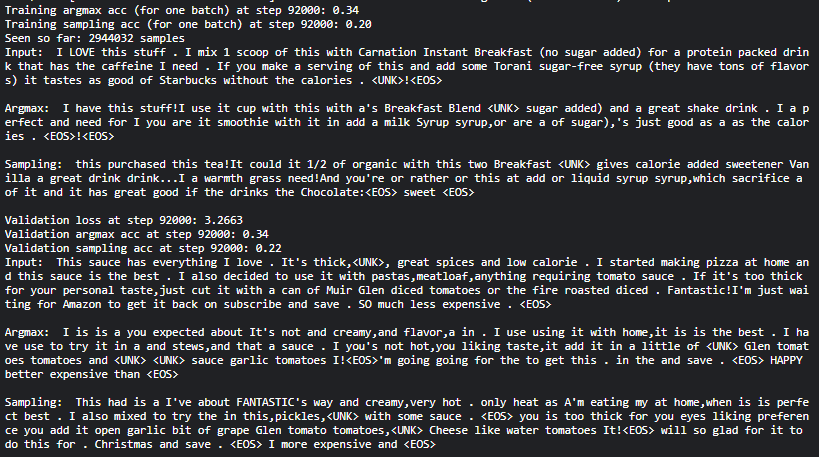
***
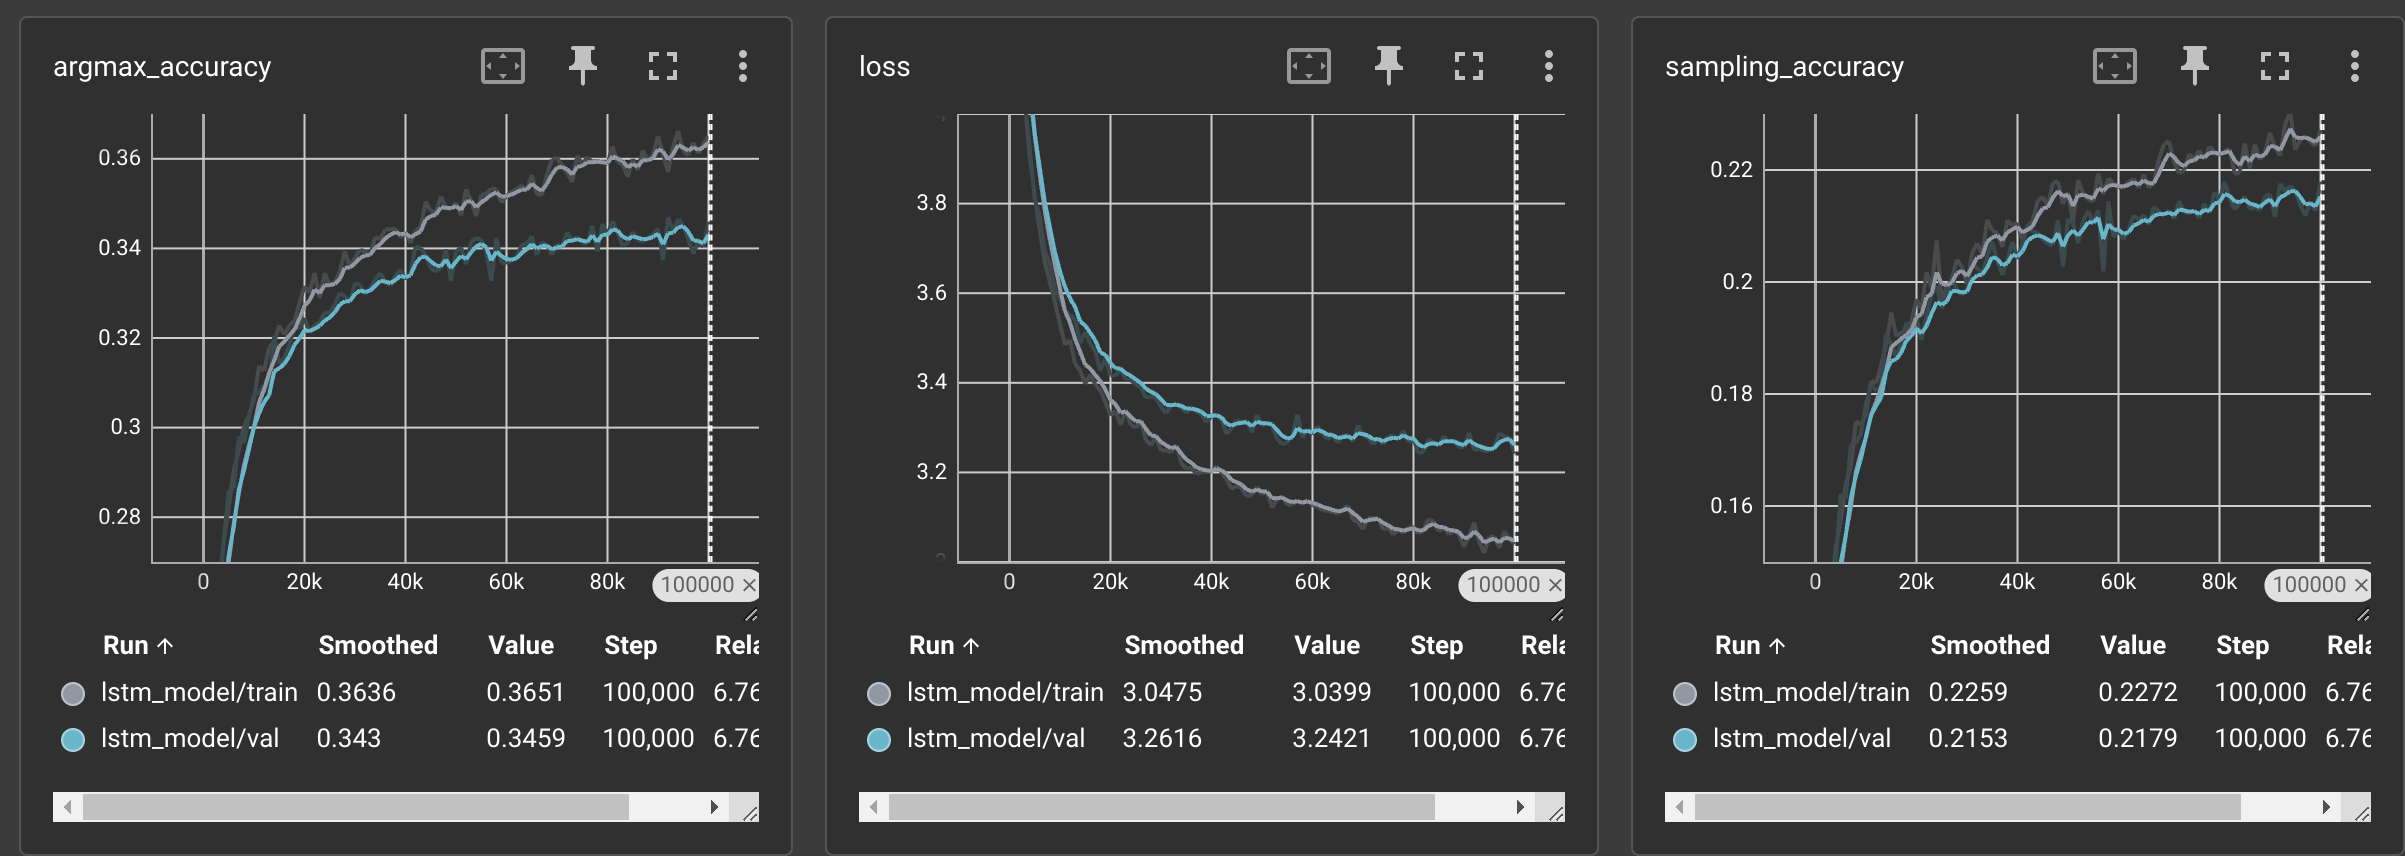
***

# Generating new review

In [30]:
lr_schedule = ExponentialDecay(initial_learning_rate=INITIAL_LEARNING_RATE,
                               decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, staircase=False, name=None)
optimizer = Adam(lr_schedule)

manager = create_checkpoint_manager(f'/kaggle/input/food-review-text-generation-model-checkpoint/{MODEL_NAME}', model, optimizer)
load_checkpoint_if_exists(manager)

Loading checkpoint from: /kaggle/input/food-review-text-generation-model-checkpoint/lstm_model/ckpt-100000


In [31]:
def tokenize_test_string(test_string):
    words_list = nltk.tokenize.word_tokenize(test_string)
    index_list = [word2idx['<SOS>']]
    for word in words_list:
        index = word2idx.get(word,word2idx['<UNK>'])
        index_list.append(index)
    return np.array(index_list).astype(np.int32)

@tf.function(input_signature=[tf.TensorSpec(shape=[1,None], dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.float32)])
def get_test_tokens(x, temperature): # (B,T)
    """
    Adding temparature to further remove randomness from random sampling.
    Concatenating last token to input for further generation.
    """
    logits = model(x, training=False)[:,-1:,:] # (B,1,C) 
    rand_uniform = tf.random.uniform(tf.shape(logits), minval=1e-5, maxval=1. - 1e-5) # (B,1,C)
    gumbel_noise = -tf.math.log(-tf.math.log(rand_uniform)) # (B,1,C)
    y_pred_sampling = tf.argmax(logits / temperature + gumbel_noise, axis=-1, output_type=tf.int32) # (B,1)
    x = tf.concat([x, y_pred_sampling], axis=1) # (B,T+1)
    return x

def detokenize_generated_review(x):
    token_list_x = []
    for token in x:
        word = idx2word[token]
        token_list_x.append(word)
    return detokenizer.detokenize(token_list_x)

def generate_review(x='', temperature=1.):
    temperature=tf.convert_to_tensor(temperature)
    x = tf.convert_to_tensor(tokenize_test_string(x))[tf.newaxis,:] # (1, T)
    for step in range(GENERATED_REVIEW_MAX_LEN):
        x = get_test_tokens(x, temperature) # (1, T)
        if x[0, -1]==word2idx['<EOS>']:
            break
    x = x[0,:].numpy() # (T,)
    return detokenize_generated_review(x)

Generating new reviews by starting a sentence and letting model predict rest of it.

**less temperature = less randomness**

In [32]:
generate_review('I bought this drink ',temperature=0.7)

"<SOS> I bought this drink for my daughter to take to school for a quick pick me up . I thought it would be fun to try new things before I bought it . It was okay but not really good . I was expecting more of a Margarita flavor . I'd like to see the pumpkin spice in it but it is not . I wouldn't buy it again . <EOS>"

In [33]:
generate_review('',temperature=0.7)

'<SOS> I have been a <UNK> <UNK> for many years . I am a big fan of <UNK> <UNK>. I am so glad that I can get it on Amazon!!!<EOS>'

In [34]:
generate_review('Pizza was delicious',temperature=0.7)

'<SOS> Pizza was delicious . I recommend this to my friends who want a quick meal . <EOS>'

In [35]:
generate_review('nom nom ',temperature=0.7)

"<SOS> nom nom!!!!!I love these!!!!!!!! I like the individual cookies . They're just the right size and not too big,not too big,not too light . They seem healthier then any chocolate chip cookies I've ever had . They are crispy and perfect for my breakfast <UNK>. I eat them for breakfast almost every morning . I eat one a day,and I love them!I have been a self diagnosed vegan diet for a couple of years . This is one of my favorite cookies . They are very crunchy and tasty . I highly recommend them!I will be buying more of these as I will not run out!<EOS>"

In [36]:
generate_review('It tasted a bit ',temperature=0.7)

"<SOS> It tasted a bit like sweet potato soup with a hint of <UNK>. It's not like <UNK>, but it's not quite there . It's got a pretty good texture . I would say the texture is nice and it's nice with a touch of sea salt on it . It's not too sweet,which is nice . <EOS>"

In [37]:
#Empty string, no temparature
generate_review()

'<SOS> Perfect . Lots of fiber,high in fiber and gluten . Lots of protein . Great as a snack right out of the jar as a snack on the run . My friends who also love the <UNK> cheese seems to love them too!<EOS>'